<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Mutational-antigenic-profiling-of-2B06-antibody-selection." data-toc-modified-id="Mutational-antigenic-profiling-of-2B06-antibody-selection.-1">Mutational antigenic profiling of 2B06 antibody selection.</a></span><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-1.1">Overview</a></span></li><li><span><a href="#Import-Python-packages" data-toc-modified-id="Import-Python-packages-1.2">Import Python packages</a></span></li><li><span><a href="#Process-deep-sequencing-data" data-toc-modified-id="Process-deep-sequencing-data-1.3">Process deep sequencing data</a></span><ul class="toc-item"><li><span><a href="#Get-information-about-samples" data-toc-modified-id="Get-information-about-samples-1.3.1">Get information about samples</a></span></li><li><span><a href="#Run-dms2_batch_bcsubamp" data-toc-modified-id="Run-dms2_batch_bcsubamp-1.3.2">Run <code>dms2_batch_bcsubamp</code></a></span></li><li><span><a href="#Look-at-summary-plots" data-toc-modified-id="Look-at-summary-plots-1.3.3">Look at summary plots</a></span></li></ul></li><li><span><a href="#Renumber-codon-counts-to-H3-numbering" data-toc-modified-id="Renumber-codon-counts-to-H3-numbering-1.4">Renumber codon counts to H3 numbering</a></span></li><li><span><a href="#Compute-differential-selection" data-toc-modified-id="Compute-differential-selection-1.5">Compute differential selection</a></span></li><li><span><a href="#Logo-plots-of-differential-selection" data-toc-modified-id="Logo-plots-of-differential-selection-1.6">Logo plots of differential selection</a></span></li><li><span><a href="#Zoomed-plots-on-sites-of-strong-escape" data-toc-modified-id="Zoomed-plots-on-sites-of-strong-escape-1.7">Zoomed plots on sites of strong escape</a></span></li><li><span><a href="#Set-up-to-enable-interactive-PDB-plotting" data-toc-modified-id="Set-up-to-enable-interactive-PDB-plotting-1.8">Set up to enable interactive PDB plotting</a></span></li></ul></li></ul></div>

# Mutational antigenic profiling of 2B06 antibody selection.

## Overview
The goal of this analysis notebook is to determine the comprehensive set of single amino-acid mutations in influenza A/WSN/33 hemagglutinin that allow for virus escape from the antibody D045-051310-2B06.
This antibody was provided by Patrick Wilson and previously characterized as a broadly cross-reactive HA [antibody](https://www.ncbi.nlm.nih.gov/pubmed/25689254). Deep mutational scanning experiments were performed by Lauren Gentles _in_ _vitro_. Selections were performed on MDCK cells and percent infectivity after antibody selection was determined by qPCR.

## Import Python packages

In [1]:
import glob
import os

from IPython.display import display, HTML

import matplotlib.pyplot as plt
plt.ion()

import pandas

import dmslogo
print(f"Using dmslogo version {dmslogo.__version__}")

import dms_tools2
from dms_tools2.ipython_utils import showPDF
print(f"Using dms_tools2 version {dms_tools2.__version__}")

# results will go in this directory
resultsdir = './results/' 
os.makedirs(resultsdir, exist_ok=True)
    
# CPUs to use, should not exceed the number you request with slurm
ncpus = 14

# do we use existing results or generate everything new?
use_existing = 'yes'

fastqdir = os.path.join(resultsdir, 'FASTQ_files/')
os.makedirs(fastqdir, exist_ok=True)
    
renumberedcountsdir = os.path.join(resultsdir, 'renumberedcounts')
os.makedirs(renumberedcountsdir, exist_ok=True)

Matplotlib is building the font cache using fc-list. This may take a moment.


Using dmslogo version 0.2.3
Using dms_tools2 version 2.6.2


## Process deep sequencing data

### Get information about samples
Here we define the samples by reading in a *.csv* file containing the selection type, library, percent infectivity, and R1 path. We then combind the selection type and the library to create the sample name. For example, the WSN library 1 selected with antibody 2B06 gets the name, '2B06-Lib.1'. We also include a mock unselected sample for comparison to identified enriched mutations in the 2B06 selected sample. The WSN-plasmid encodes the wildtype HA sequence and will served as an error control in this analysis. There are two separate error control samples in this analysis since two different sequencing runs were required to produce the data.

In [2]:
samples = pandas.read_csv('data/samplelist.csv')
samples['name'] = samples.selection + '-' + samples.library

display(HTML(samples.to_html(index=False)))

selection,library,percent_infectivity,R1,name
2B06,Lib.1,0.17,/fh/fast/bloom_j/SR/ngs/illumina/lgentles/190419_M03100_0418_000000000-CCW7R/Data/Intensities/BaseCalls/2B06-50ug_S1_L001_R1_001.fastq.gz,2B06-Lib.1
Mock,Lib.1,,/fh/fast/bloom_j/SR/ngs/illumina/lgentles/190419_M03100_0418_000000000-CCW7R/Data/Intensities/BaseCalls/Lib1-mock-rep2_S3_L001_R1_001.fastq.gz,Mock-Lib.1
WSN-plasmid,,,/fh/fast/bloom_j/SR/ngs/illumina/lgentles/190419_M03100_0418_000000000-CCW7R/Data/Intensities/BaseCalls/WSN-HA-plasmid_S2_L001_R1_001.fastq.gz,WSN-plasmid-
2B06,Lib.2,0.10,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190524_M04866_0253_000000000-CGDFR_new-demux/Data/Intensities/BaseCalls/Lib2-2B06-25ug_S1_L001_R1_001.fastq.gz,2B06-Lib.2
Mock,Lib.2,,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190524_M04866_0253_000000000-CGDFR_new-demux/Data/Intensities/BaseCalls/Lib2-mock_S2_L001_R1_001.fastq.gz,Mock-Lib.2
2B06,Lib.3,0.14,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190524_M04866_0253_000000000-CGDFR_new-demux/Data/Intensities/BaseCalls/Lib3-2B06-25ug_S3_L001_R1_001.fastq.gz,2B06-Lib.3
Mock,Lib.3,,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190524_M04866_0253_000000000-CGDFR_new-demux/Data/Intensities/BaseCalls/Lib3-mock_S4_L001_R1_001.fastq.gz,Mock-Lib.3
WSN-HA-plasmid,,,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190524_M04866_0253_000000000-CGDFR_new-demux/Data/Intensities/BaseCalls/WSN-HA-plasmid_S5_L001_R1_001.fastq.gz,WSN-HA-plasmid-


### Run `dms2_batch_bcsubamp`
*dms2_batch_bcsubamp* aligns the sequencing reads and counts the frequency of mutations observed.

In [3]:
# file containing wildtype WSN HA sequence
refseq = './data/WSN-HA.fasta'

# define subamplicon alignment specifications
alignspecs = ' '.join(['1,285,36,37', 
                       '286,570,31,32',
                       '571,855,37,32',
                       '856,1140,31,36',
                       '1141,1425,29,33',
                       '1426,1698,40,43'])

# counts and alignments placed in this directory
countsdir = os.path.join(resultsdir, 'codoncounts')
if not os.path.isdir(countsdir):
    os.mkdir(countsdir)
    
# write sample information to a batch file for dms2_batch_bcsubamplicons
countsbatchfile = os.path.join(countsdir, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(samples[['name', 'R1']].to_html(index=False)))
samples[['name', 'R1']].to_csv(countsbatchfile, index=False)

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir} \
        --summaryprefix summary \
        --R1trim 200 \
        --R2trim 170 \
        --fastqdir {fastqdir} \
        --ncpus {ncpus} \
        --use_existing {use_existing} 

print("Completed dms2_batch_bcsubamp.")

Here is the batch file that we write to CSV format to use as input:


name,R1
2B06-Lib.1,/fh/fast/bloom_j/SR/ngs/illumina/lgentles/190419_M03100_0418_000000000-CCW7R/Data/Intensities/BaseCalls/2B06-50ug_S1_L001_R1_001.fastq.gz
Mock-Lib.1,/fh/fast/bloom_j/SR/ngs/illumina/lgentles/190419_M03100_0418_000000000-CCW7R/Data/Intensities/BaseCalls/Lib1-mock-rep2_S3_L001_R1_001.fastq.gz
WSN-plasmid-,/fh/fast/bloom_j/SR/ngs/illumina/lgentles/190419_M03100_0418_000000000-CCW7R/Data/Intensities/BaseCalls/WSN-HA-plasmid_S2_L001_R1_001.fastq.gz
2B06-Lib.2,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190524_M04866_0253_000000000-CGDFR_new-demux/Data/Intensities/BaseCalls/Lib2-2B06-25ug_S1_L001_R1_001.fastq.gz
Mock-Lib.2,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190524_M04866_0253_000000000-CGDFR_new-demux/Data/Intensities/BaseCalls/Lib2-mock_S2_L001_R1_001.fastq.gz
2B06-Lib.3,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190524_M04866_0253_000000000-CGDFR_new-demux/Data/Intensities/BaseCalls/Lib3-2B06-25ug_S3_L001_R1_001.fastq.gz
Mock-Lib.3,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190524_M04866_0253_000000000-CGDFR_new-demux/Data/Intensities/BaseCalls/Lib3-mock_S4_L001_R1_001.fastq.gz
WSN-HA-plasmid-,/fh/fast/bloom_j/SR/ngs/illumina/bloom_lab/190524_M04866_0253_000000000-CGDFR_new-demux/Data/Intensities/BaseCalls/WSN-HA-plasmid_S5_L001_R1_001.fastq.gz



Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


### Look at summary plots
The `*_readstats.pdf` summary plot shows the number of reads that were retained or thrown away due to low quality barcodes. The black regions indicate reads that failed the Illumina filter.

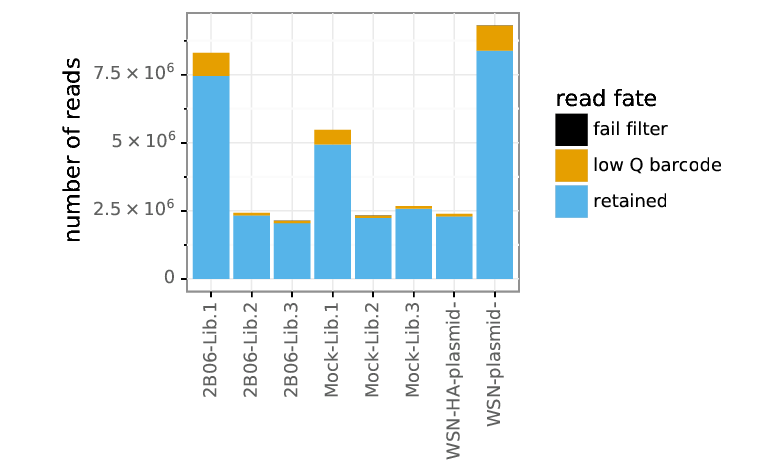

In [4]:
countsplotprefix = os.path.join(countsdir, 'summary')
showPDF(countsplotprefix + '_readstats.pdf', width=700)

The `*_readsperbc.pdf` summary plot shows the number of times each barcode was read for each sample.

The distributions for this analysis look good except for the Lib.1 mock sample which could use greater sequencing depth. The Lib.2 and Lib.3 samples could also benefit from increased sequencing depth, but look pretty good for the most part.

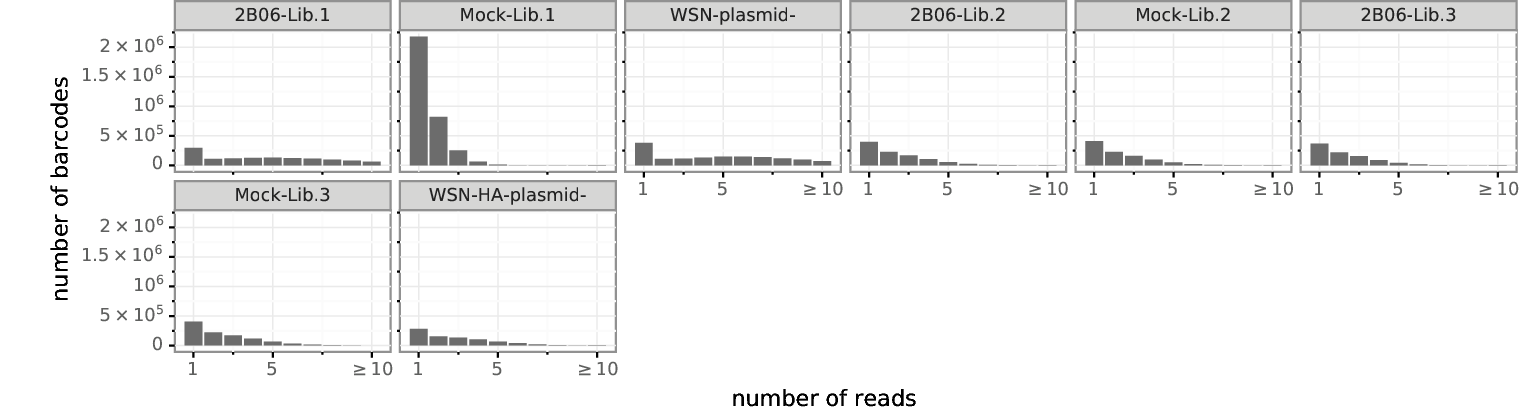

In [5]:
showPDF(countsplotprefix + '_readsperbc.pdf')

The `*_bcstats.pdf` summary plot shows the number of barcodes that were able to be aligned to the reference WSN HA sequence. It will also show the number of barcodes that were not able to be alligned either because the barcode was not read enough times or the sequence just could not be aligned to the reference sequence.

You can see here that the mock sample that was not sequenced to a great enough depth and has many barcodes thrown out due to too few reads.

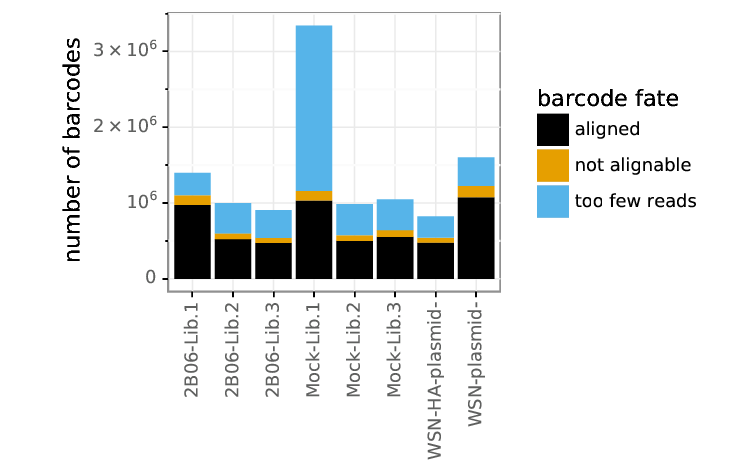

In [6]:
showPDF(countsplotprefix + '_bcstats.pdf', width=700)

The `*_depth.pdf` summary plot the depth (e.g. the number of reads for each codon) across the entire HA. This shows how well the barcodes were evenly represented between the different subamplicons.

The coverage looks good for most of these samples with the Lib.2 and Lib.3 having particularly even coverage.

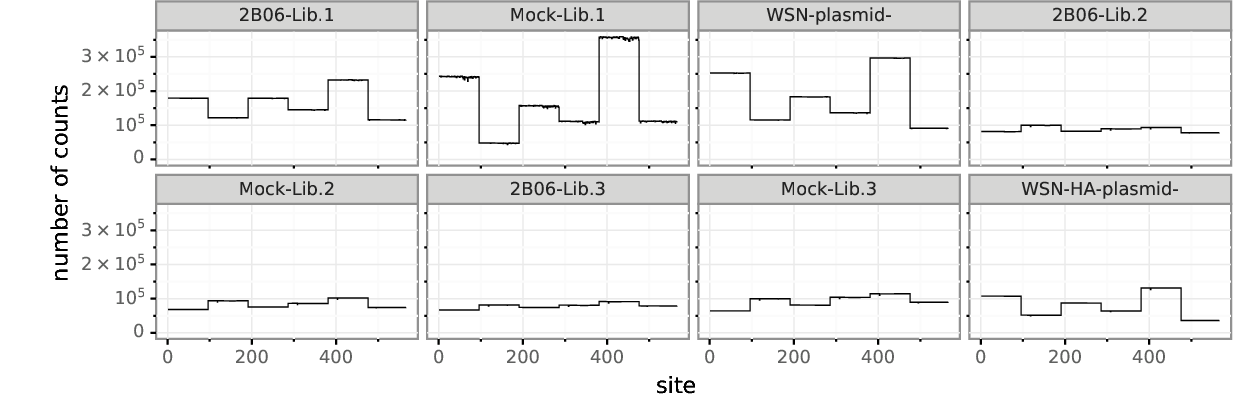

In [7]:
showPDF(countsplotprefix + '_depth.pdf')

The `*_mutfreq.pdf` summary plot shows the per codon frequency of mutations ar each site. In other words, it is the it is the cummulative number of mutations different from the reference sequence at each site.

We can clearly see increases in mutation frequency here in our selected samples.

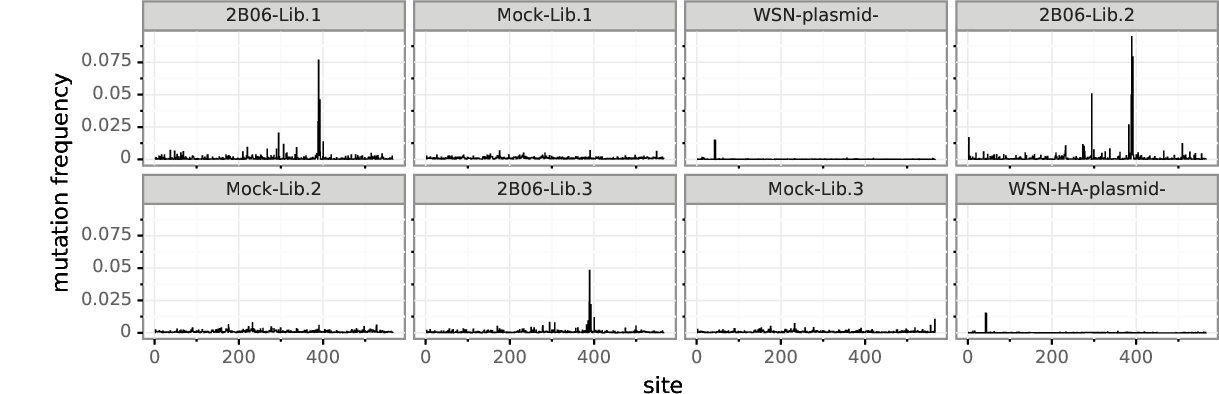

In [8]:
showPDF(countsplotprefix + '_mutfreq.pdf')

The `*_cumulmutcounts.pdf` plot below shows the fraction fo mutations that are found less than or equal to the number of times indicated on the x-axis.

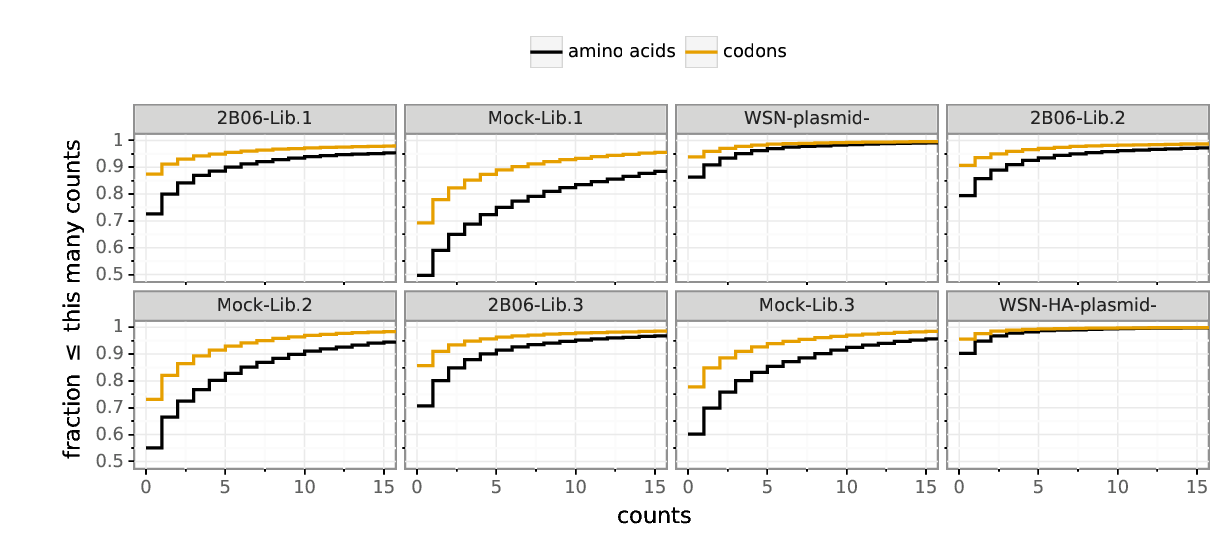

In [9]:
showPDF(countsplotprefix + '_cumulmutcounts.pdf')

The `*_codonmuttypes.pdf` summary plot the per-codon frequency of nonsynonymous, synonymous, and stop codon mutation across the entire gene.

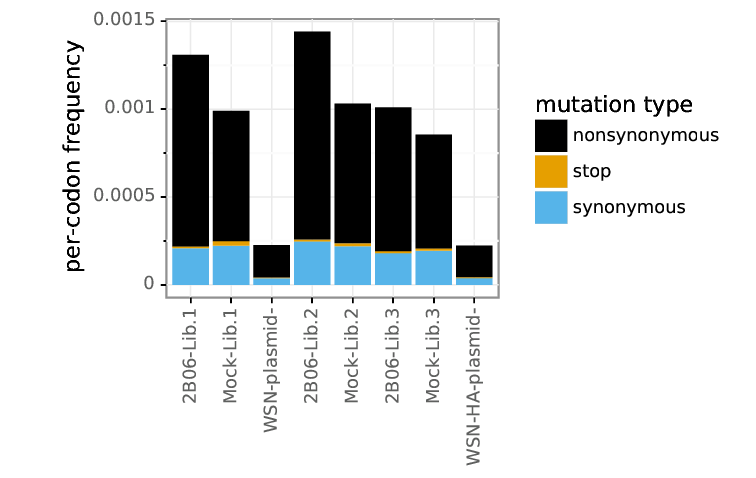

In [10]:
showPDF(countsplotprefix + '_codonmuttypes.pdf', width=700)

The `*_codonmuttypes.csv` summary file shows the nummerical values for the data above.

In [11]:
codonmuttypes = pandas.read_csv(countsplotprefix + '_codonmuttypes.csv').sort_index(axis=1)
display(HTML(codonmuttypes.to_html(index=False)))

name,nonsynonymous,stop,synonymous
2B06-Lib.1,0.001091,0.000010,0.000209
Mock-Lib.1,0.000741,0.000027,0.000223
WSN-plasmid-,0.000185,0.000004,0.000037
2B06-Lib.2,0.001183,0.000011,0.000248
Mock-Lib.2,0.000794,0.000017,0.000220
2B06-Lib.3,0.000819,0.000011,0.000181
Mock-Lib.3,0.000647,0.000013,0.000194
WSN-HA-plasmid-,0.000181,0.000005,0.000039


The `*_codonntchanges.pdf` summary plot shows the frequency of the number of nucleotide mutations that make up a given codon mutation (e.g., ATG to AAG changes 1 nucleotide, ATG to AAC changes 2 nucleotides, and ATG to CAC changes 3 nucleotides).

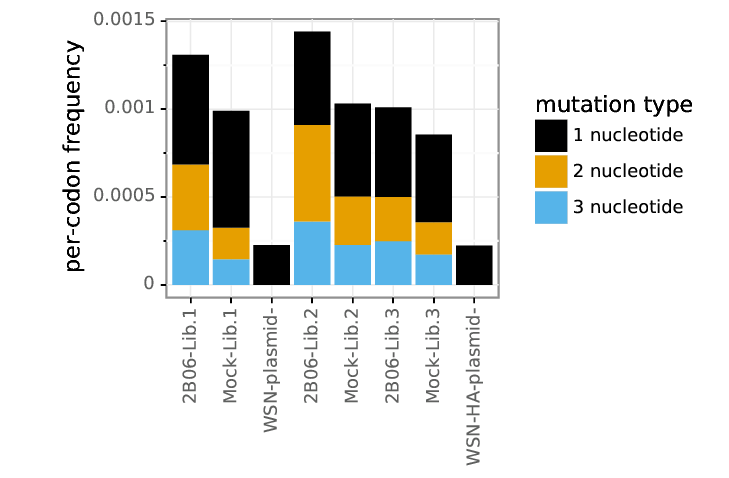

In [12]:
showPDF(countsplotprefix + '_codonntchanges.pdf', width=700)

The `*_singlentchanges.pdf` plot below shows the frequency of each type of nucleotide change among only codon mutations with one nucleotide change. This plot is mostly useful to check if there is a large bias in which mutations appear. In particular, if you are getting oxidative damage (which causes G to T mutations) during the library preparation process, you will see a large excess of C to A or G to T mutations (or both). For instance, in the case of influenza, when we get bad oxidative damage, then we see an excess of C to A mutations in the final cDNA since the damage is occurring to a ssRNA genome. If you are sequencing something without polarity, you might see both types of mutations

It seems like I am seeing mild C to A oxidative damage in my lib 1 mock sample. This is not entirely suprising since I used older amplicons to generate this sample.

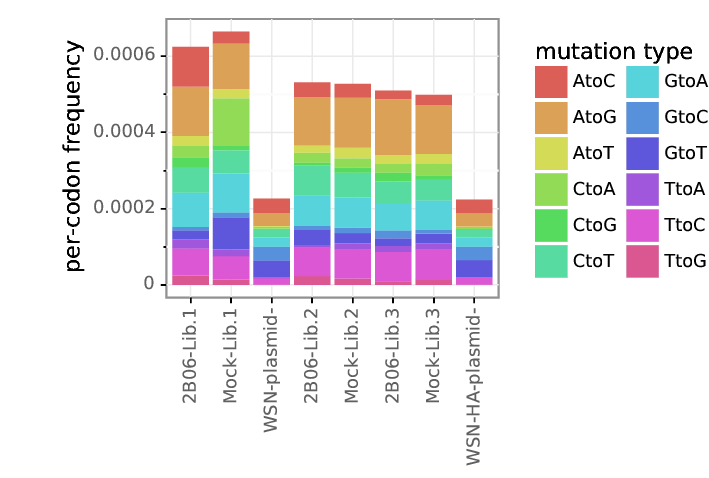

In [13]:
showPDF(countsplotprefix + '_singlentchanges.pdf', width=700)

## Renumber codon counts to H3 numbering
We will now renumber the codon counts from sequential (1, 2, ... starting from the initial Met) to H3 numbering. The signal peptide is numbered with negative values, and the HA1 and HA2 subunits are numbered separately. This numbering scheme is based on an alignment to a PDB structure for an H3 HA [4HMG](https://www.rcsb.org/structure/4HMG). We will use:

1. The [./data/H1toH3_renumber.csv](./data/H1toH3_renumber.csv) file to convert the sequential numbers into the H3 numbering scheme
2. The [dms_tools2.utils.renumberSites](https://jbloomlab.github.io/dms_tools2/dms_tools2.utils.html#dms_tools2.utils.renumberSites) function to renumber the codon counts files

The renumbered files will be created in a new renumberedcounts directory and will possess the same names as the original codon counts files created from [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html) above.

In [14]:
renumberfile = './data/H1toH3_renumber.csv'

# counts files to renumber
countsfiles = glob.glob('{0}/*codoncounts.csv'.format(countsdir))

dms_tools2.utils.renumberSites(renumberfile, countsfiles, missing='drop', 
        outdir=renumberedcountsdir)

## Compute differential selection
We first create a batch file to use with [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html). Note that we make the group arguments such that the samples taken from the same day with the same virus dose are compared with appropriate no antibody controls using the counts files generated above with [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html).

By grouping the replicates for the same antibody concentration and virus dose together in the batch file, we tell [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html) to analyze these together and take their mean and median.

In [15]:
diffseldir = os.path.join(resultsdir, 'diffsel')
if not os.path.isdir(diffseldir):
    os.mkdir(diffseldir)

diffselbatchfile = os.path.join(diffseldir, 'batch.csv')
    
# create batch file for dms2_batch_diffsel
diffselbatch = pandas.DataFrame.from_records([
              # WSN library 1 selected with 50ug/mL of D045_051310_2B06
              ('2B06', '2B06-Lib.1', '2B06-Lib.1', 'Mock-Lib.1', 'WSN-plasmid-'),
              ('2B06', '2B06-Lib.2', '2B06-Lib.2', 'Mock-Lib.2', 'WSN-plasmid-'),
              ('2B06', '2B06-Lib.3', '2B06-Lib.3', 'Mock-Lib.3', 'WSN-plasmid-'),
             ],
             columns=['group', 'name', 'sel', 'mock', 'err']
             )

print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(diffselbatch.to_html(index=False)))

diffselbatch.to_csv(diffselbatchfile, index=False)

Here is the batch file that we write to CSV format to use as input:


group,name,sel,mock,err
2B06,2B06-Lib.1,2B06-Lib.1,Mock-Lib.1,WSN-plasmid-
2B06,2B06-Lib.2,2B06-Lib.2,Mock-Lib.2,WSN-plasmid-
2B06,2B06-Lib.3,2B06-Lib.3,Mock-Lib.3,WSN-plasmid-


Now we simply run [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html), getting the input counts from the directroy (--indir) where we placed the counts when we ran [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html).

In [16]:
log = !dms2_batch_diffsel \
        --summaryprefix summary \
        --batchfile {diffselbatchfile} \
        --outdir {diffseldir} \
        --indir {renumberedcountsdir} \
        --use_existing {use_existing}

Running this command creates a large number of output files giving the mutation and site [differential selection](https://jbloomlab.github.io/dms_tools2/diffsel.html) values in the formats of the mutdiffsel.csv and sitediffsel.csv files created by [dms2_diffsel](https://jbloomlab.github.io/dms_tools2/diffsel.html).

Specifically, there is a file for each individual sample, with a file name that gives the group and name specified for this sample in `--batchfile`.

In [17]:
!ls {diffseldir}/

2B06-2B06-Lib.1.log
2B06-2B06-Lib.1_mutdiffsel.csv
2B06-2B06-Lib.1_sitediffsel.csv
2B06-2B06-Lib.2.log
2B06-2B06-Lib.2_mutdiffsel.csv
2B06-2B06-Lib.2_sitediffsel.csv
2B06-2B06-Lib.3.log
2B06-2B06-Lib.3_mutdiffsel.csv
2B06-2B06-Lib.3_sitediffsel.csv
2B06_diffsel.pdf
2B06.log
batch.csv
line_and_logo_plot.pdf
summary_2B06-absolutesitediffselcorr.pdf
summary_2B06-maxmutdiffselcorr.pdf
summary_2B06-meanmutdiffsel.csv
summary_2B06-meansitediffsel.csv
summary_2B06-medianmutdiffsel.csv
summary_2B06-mediansitediffsel.csv
summary_2B06-mutdiffselcorr.pdf
summary_2B06-positivesitediffselcorr.pdf
summary.log
summary_meanmaxdiffsel.pdf
summary_meanminmaxdiffsel.pdf
summary_meanpositivediffsel.pdf
summary_meantotaldiffsel.pdf
summary_medianmaxdiffsel.pdf
summary_medianminmaxdiffsel.pdf
summary_medianpositivediffsel.pdf
summary_mediantotaldiffsel.pdf
tidy_diffsel.csv


Now we are going to look at the correlation of samples within a given group.

Running [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html) creates correlation plots for the mutation differential selection, positive site differential selection, absolute site differential selection, and maximum mutation differential selection for a site. These files have names like `summary_2B06-Lib.1-mutdiffselcorr.pdf`. Below we show the plot `positivesiteddiffsel`, which is the main statistic that we are looking at here:


positivesitediffsel correlations:


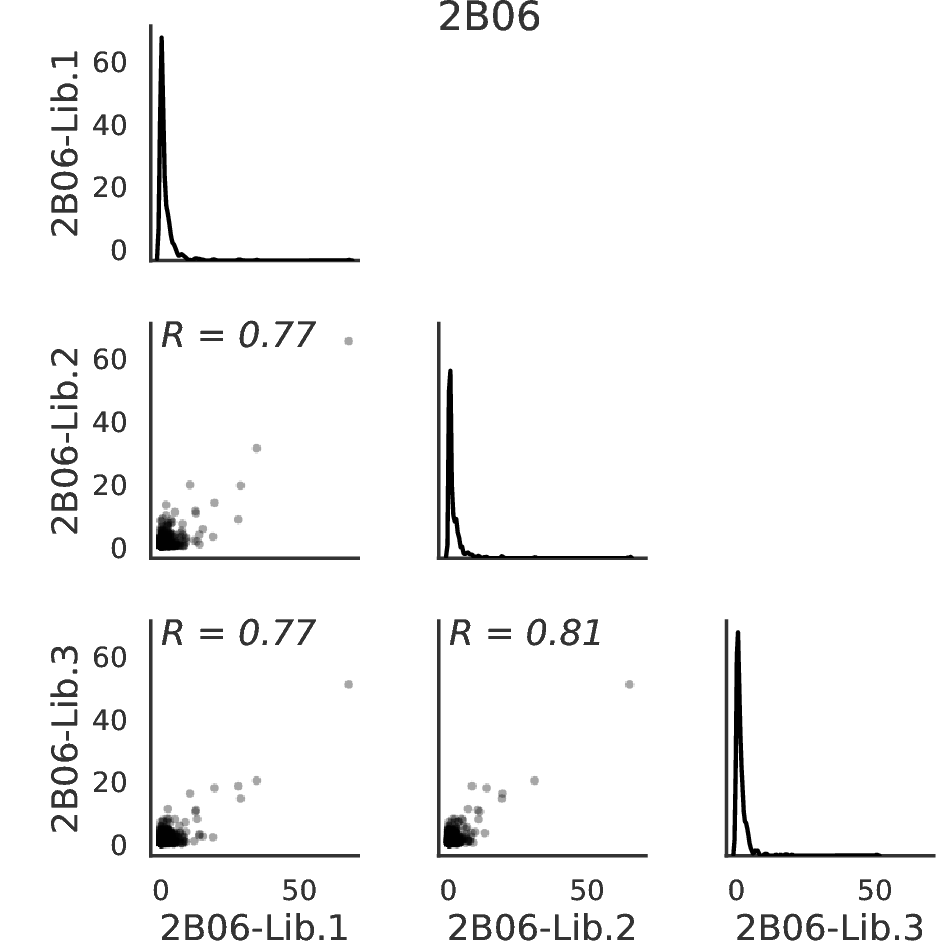

In [18]:
diffselprefix = os.path.join(diffseldir, 'summary_')
groups = diffselbatch['group'].unique()

for seltype in ['positivesitediffsel']:
    print("\n{0} correlations:".format(seltype))
    plots = []
    for g in groups:
        plot = diffselprefix + g + '-' + seltype + 'corr.pdf'
        plots.append(plot)
    showPDF(plots) 

Probably the most informative plot is simply the median positive site differential selection. This plot show the total positive selection for all mutations combined at a give site as shown below.

This one of the most informative plots here showing strong possitive differential selection at few sites in the stem region of HA.

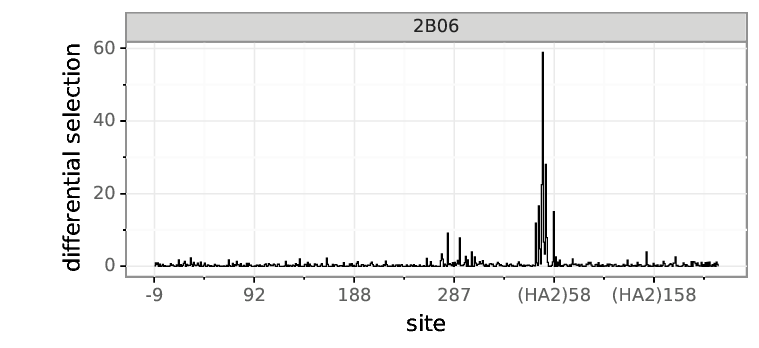

In [19]:
showPDF(diffselprefix + 'medianpositivediffsel.pdf', width=800)

## Logo plots of differential selection
The most comprehensive way to show this selection is in the form of logo plots that can be created with [dms2_logoplot](https://jbloomlab.github.io/dms_tools2/dms2_logoplot.html).

We make those logog plots using the median mutation differential selection values returned by [dms2_batch_diffsel](https://jbloomlab.github.io/dms_tools2/dms2_batch_diffsel.html). The reason that we plot the median rather than the mean is that we have noticed that is is often cleaner when there are >2 replicates.

We also add underlays of the wildtype sequence. To add the wildtype sequence, we can simply specify any file with the columns `wildtype` and `site --` any of our mutdiffsel files suffice. note that we add this using the -overlay1 option, and then convert it to an underlay with `--underlay yes` since underlays look better than overlays here.

Note that this logoplot uses the converted H3 numbering asigned above.

First we get a data frame with all of the medians across groups:

In [20]:
median_files = (diffselbatch[['group']]
                .drop_duplicates()
                .assign(medianmutfile=lambda x: diffselprefix + x['group'] + '-medianmutdiffsel.csv',
                        mediansitefile=lambda x: diffselprefix + x['group'] + '-mediansitediffsel.csv')
                )

display(HTML(median_files.to_html(index=False)))

group,medianmutfile,mediansitefile
2B06,./results/diffsel/summary_2B06-medianmutdiffsel.csv,./results/diffsel/summary_2B06-mediansitediffsel.csv


Build a logo plot for each group:


Creating logo plot for 2B06 from ./results/diffsel/summary_2B06-medianmutdiffsel.csv


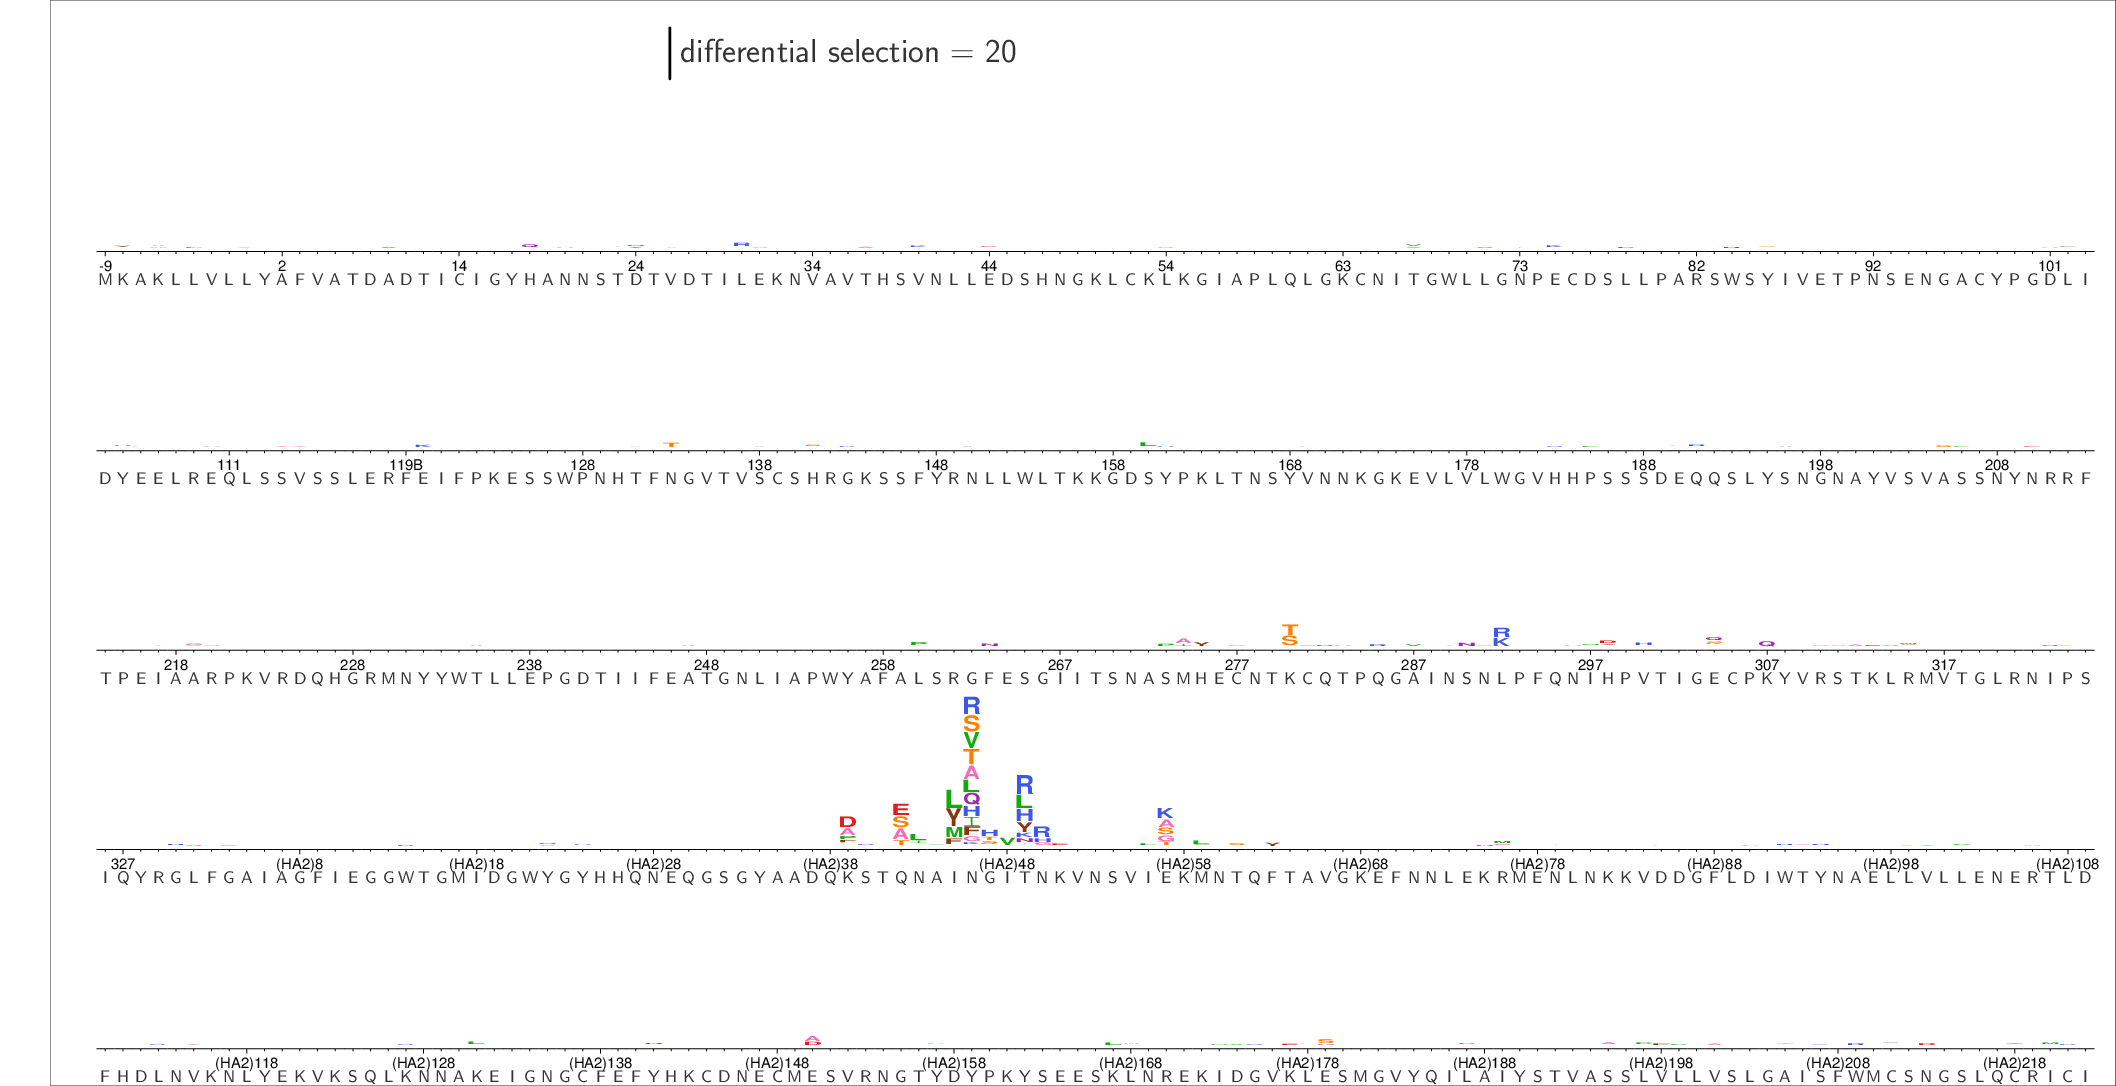

In [21]:
for tup in median_files.itertuples(index=False):

    logoplot = os.path.join(diffseldir, '{0}_diffsel.pdf'.format(tup.group))
    print("\nCreating logo plot for {0} from {1}".format(tup.group, tup.medianmutfile))
    
    log = !dms2_logoplot \
            --diffsel {tup.medianmutfile} \
            --name {tup.group} \
            --outdir {diffseldir} \
            --restrictdiffsel positive \
            --sepline no \
            --nperline 113 \
            --overlay1 {tup.medianmutfile} wildtype wildtype \
            --underlay yes \
            --use_existing {use_existing} \
            --scalebar 20 "differential selection = 20"
    showPDF(logoplot)

This analysis, similarly to the positive differential selection line plot above, shows strong selection at a few sites in the stem region of HA. Several sites in the stem domain show varing degrees of selection with site (HA2)46 appearing to have the strongest effect. Interestingly, it appears that many different mutations at this site confer escape indicating most mutations away from the wildtype sequence allow for escape. Further Dunand et al. 2015 identified escape mutations in H7 at sites V318I and I384N, which are also located in the HA stem domain, and G195E, located in the head domain. Considering the differences between H1 and H7 there are striking similarities in the selected sites. We do not identify any head escape mutations in our selection experiments here, but this could be due to strain specific differences.

## Zoomed plots on sites of strong escape
First use [dms_tools2.diffsel.df_read_filecols](https://jbloomlab.github.io/dms_tools2/dms_tools2.diffsel.html#dms_tools2.diffsel.df_read_filecols) to read the median differential selection into a tidy data frame.
First get names of all of the median files:

In [22]:
sel_df = (dms_tools2.diffsel.df_read_filecols(median_files, ['medianmutfile', 'mediansitefile'])
          .rename(columns={'group': 'antibody'})
          [['antibody', 'isite', 'site', 'positive_diffsel', 'wildtype', 'mutation', 'mutdiffsel']]
          )

See how the selection is now in a tidy data frame:

In [23]:
display(HTML(sel_df.head().to_html(index=False)))

antibody,isite,site,positive_diffsel,wildtype,mutation,mutdiffsel
2B06,391,(HA2)49,28.030697,T,R,7.837088
2B06,391,(HA2)49,28.030697,T,L,5.609973
2B06,391,(HA2)49,28.030697,T,H,5.083673
2B06,391,(HA2)49,28.030697,T,Y,4.185196
2B06,391,(HA2)49,28.030697,T,K,2.143734


Get sites of "strong" or "significant" escape (**Note**: this next cell currently only works if you have just one antibody):

In [24]:
sel_df, _, _ = dms_tools2.plot.findSigSel(sel_df, 'positive_diffsel', '.temp', fdr=0.5)
sel_df = sel_df.drop(columns=['P', 'Q'])

Now there is a column "sig" indicating "strong" or "significant" sites of escape:

In [25]:
display(HTML(sel_df.head().to_html(index=False)))

antibody,isite,site,positive_diffsel,wildtype,mutation,mutdiffsel,sig
2B06,391,(HA2)49,28.030697,T,R,7.837088,True
2B06,391,(HA2)49,28.030697,T,L,5.609973,True
2B06,391,(HA2)49,28.030697,T,H,5.083673,True
2B06,391,(HA2)49,28.030697,T,Y,4.185196,True
2B06,391,(HA2)49,28.030697,T,K,2.143734,True


Here are all those "significant" sites:

In [26]:
display(HTML(
 sel_df
 .query('sig')
 [['antibody', 'site', 'positive_diffsel']]
 .drop_duplicates()
 .sort_values('site')
 .reset_index(drop=True)
 .to_html(index=False)
 ))

antibody,site,positive_diffsel
2B06,280,9.142997
2B06,292,7.822881
2B06,(HA2)39,11.901355
2B06,(HA2)42,16.633897
2B06,(HA2)45,22.484858
2B06,(HA2)46,58.887742
2B06,(HA2)47,6.663881
2B06,(HA2)49,28.030697
2B06,(HA2)50,7.869357
2B06,(HA2)57,15.020422


Prep for plotting by adding site labels:

In [27]:
sel_df = (
    sel_df
    .assign(site_label=lambda x: x['wildtype'] + x['site'].astype('str'))
    )

Now make and save zoomed logo plot:

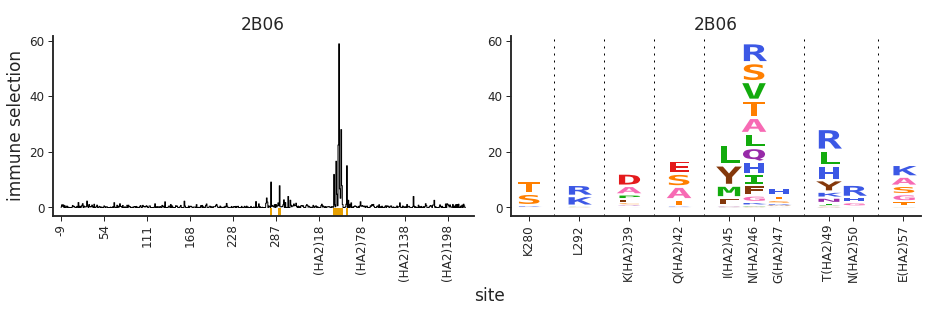

Saving to ./results/diffsel/line_and_logo_plot.pdf


In [28]:
line_logo_plot = os.path.join(diffseldir, 'line_and_logo_plot.pdf')

fig, axes = dmslogo.facet_plot(
        data=sel_df,
        x_col='isite',
        show_col='sig',
        gridrow_col='antibody',
        share_xlabel=True,
        share_ylabel=True,
        share_ylim_across_rows=True,
        wspace=0.6,
        draw_line_kwargs=dict(
                height_col='positive_diffsel',
                xtick_col='site',
                ylabel='immune selection',
                ),
        draw_logo_kwargs=dict(
                letter_col='mutation',
                letter_height_col='mutdiffsel',
                xtick_col='site_label',
                xlabel='site',
                ylabel='immune selection',
                clip_negative_heights=True,
                ),
        )
display(fig)
print(f"Saving to {line_logo_plot}")
fig.savefig(line_logo_plot)
plt.close(fig)

## Set up to enable interactive PDB plotting
So to do this, we need to add columns called `pdb_chain` and `pdb_site` giving the chain and site number for each residue in the PDB.

We will use the PDB [1rvx](https://www.rcsb.org/structure/1RVX), and we've created the file [./data/H3_site_to_PDB_1rvx.csv](data/H3_site_to_PDB_1rvx.csv) which maps the H3 site numbering to this PDB.
We then very clearly label what all of the different site numbering schemes mean:
  - we have sequential 0, 1, 2, ... numbering
  - we have H3 numbering
  - we have 1RVX PDB site and chain numbering:

In [29]:
sel_df_pdb_numbers = (
 sel_df
 .merge(pandas.read_csv('data/H3_site_to_PDB_1rvx.csv'), how='left')
 .rename(columns={'site': 'H3_site',
                  'pdb_chain': 'PDB_1rvx_chain',
                  'pdb_site': 'PDB_1rvx_site',
                  'site_label': 'H3_site_label'})
 .assign(PDB_1rvx_site_label=lambda x: x['PDB_1rvx_site'] +
                                       x['PDB_1rvx_chain'].apply(lambda c: '' if c == 'A' else '(HA2)'))
 )

display(HTML(sel_df_pdb_numbers.head().to_html(index=False)))

tidy_sel_file = os.path.join(diffseldir, 'tidy_diffsel.csv')
print(f"Writing this data frame to {tidy_sel_file}")
sel_df_pdb_numbers.to_csv(tidy_sel_file, index=False)

antibody,isite,H3_site,positive_diffsel,wildtype,mutation,mutdiffsel,sig,H3_site_label,PDB_1rvx_chain,PDB_1rvx_site,PDB_1rvx_site_label
2B06,391,(HA2)49,28.030697,T,R,7.837088,True,T(HA2)49,B,549,549(HA2)
2B06,391,(HA2)49,28.030697,T,L,5.609973,True,T(HA2)49,B,549,549(HA2)
2B06,391,(HA2)49,28.030697,T,H,5.083673,True,T(HA2)49,B,549,549(HA2)
2B06,391,(HA2)49,28.030697,T,Y,4.185196,True,T(HA2)49,B,549,549(HA2)
2B06,391,(HA2)49,28.030697,T,K,2.143734,True,T(HA2)49,B,549,549(HA2)


Writing this data frame to ./results/diffsel/tidy_diffsel.csv
